In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

path = r'C:\Users\KIIT\Desktop\ibm\ml-latest-small'
ratings = pd.read_csv(f'{path}/ratings.csv')
movies = pd.read_csv(f'{path}/movies.csv')
tags = pd.read_csv(f'{path}/tags.csv')
links = pd.read_csv(f'{path}/links.csv')

print("Dataset shapes:")
print(f"Ratings: {ratings.shape}")
print(f"Movies: {movies.shape}")
print(f"Tags: {tags.shape}")
print(f"Links: {links.shape}")


Dataset shapes:
Ratings: (100836, 4)
Movies: (9742, 3)
Tags: (3683, 4)
Links: (9742, 3)


Rating Statistics:
count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Unique users: 610
Unique movies: 9724

Rating Distribution:
rating
0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211
Name: count, dtype: int64


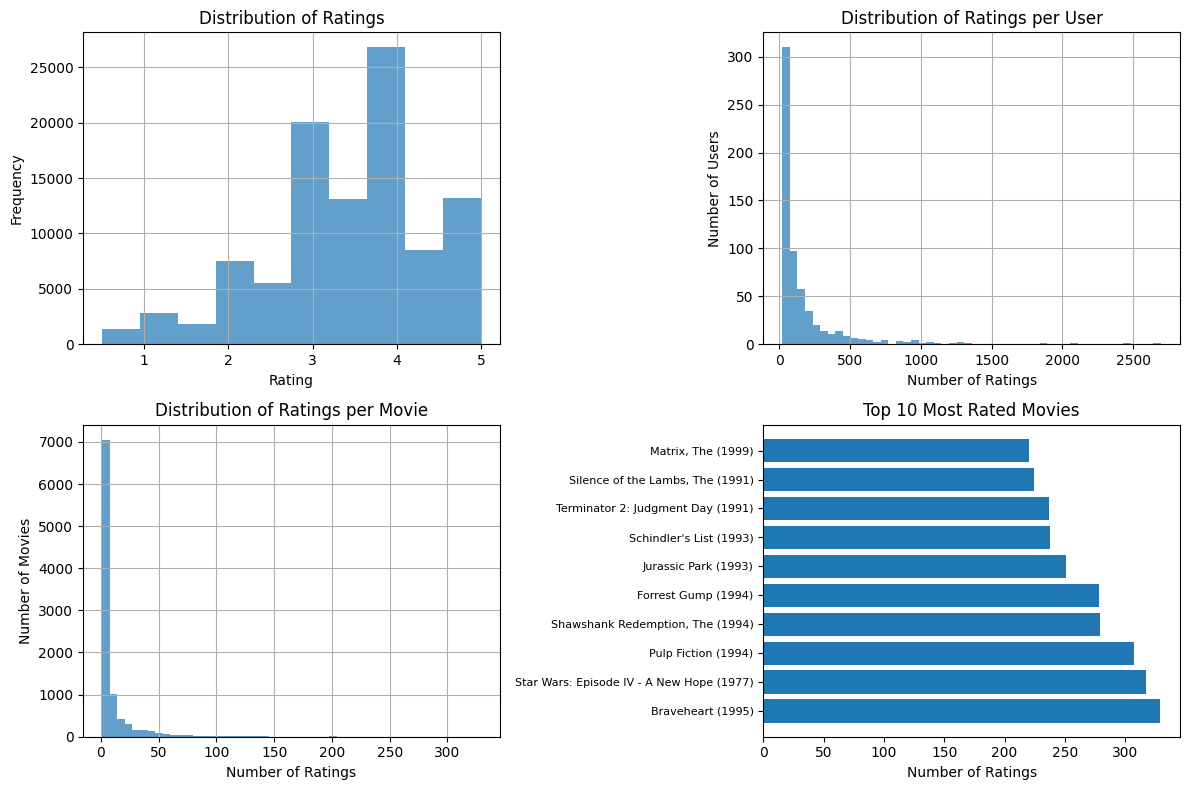


Top 10 Genres:
Drama        4361
Comedy       3756
Thriller     1894
Action       1828
Romance      1596
Adventure    1263
Crime        1199
Sci-Fi        980
Horror        978
Fantasy       779
Name: count, dtype: int64


In [2]:
ratings_stats = ratings['rating'].describe()
print("Rating Statistics:")
print(ratings_stats)

num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()
print(f"\nUnique users: {num_users}")
print(f"Unique movies: {num_movies}")

ratings_distribution = ratings['rating'].value_counts().sort_index()
print("\nRating Distribution:")
print(ratings_distribution)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
ratings['rating'].hist(bins=10, alpha=0.7)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
user_rating_counts = ratings['userId'].value_counts()
user_rating_counts.hist(bins=50, alpha=0.7)
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')

plt.subplot(2, 2, 3)
movie_rating_counts = ratings['movieId'].value_counts()
movie_rating_counts.hist(bins=50, alpha=0.7)
plt.title('Distribution of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')

plt.subplot(2, 2, 4)
top_movies = ratings['movieId'].value_counts().head(10)
top_movies_titles = movies[movies['movieId'].isin(top_movies.index)]['title'].head(10)
plt.barh(range(len(top_movies_titles)), top_movies.head(10).values)
plt.yticks(range(len(top_movies_titles)), top_movies_titles, fontsize=8)
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')

plt.tight_layout()
plt.show()

genres_split = movies['genres'].str.split('|', expand=True)
all_genres = pd.concat([genres_split[col].dropna() for col in genres_split.columns])
genre_counts = all_genres.value_counts()
print("\nTop 10 Genres:")
print(genre_counts.head(10))


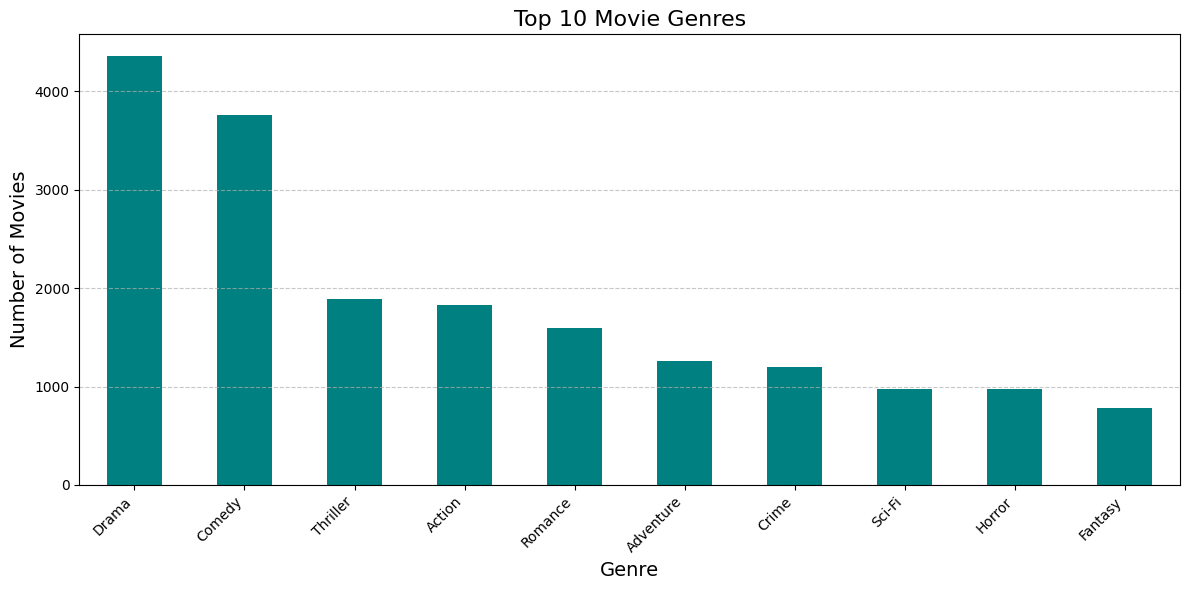

In [3]:
# Create a bar plot for the top 10 genres
plt.figure(figsize=(12, 6))
genre_counts.head(10).plot(kind='bar', color='teal')
plt.title('Top 10 Movie Genres', fontsize=16)
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Number of Users')

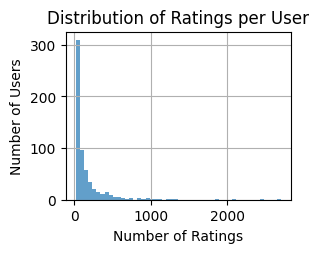

In [4]:
plt.subplot(2, 2, 2)
user_rating_counts = ratings['userId'].value_counts()
user_rating_counts.hist(bins=50, alpha=0.7)
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')

Text(0.5, 0, 'Number of Ratings')

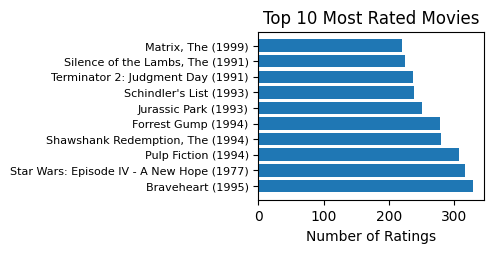

In [5]:
plt.subplot(2, 2, 4)
top_movies = ratings['movieId'].value_counts().head(10)
top_movies_titles = movies[movies['movieId'].isin(top_movies.index)]['title'].head(10)
plt.barh(range(len(top_movies_titles)), top_movies.head(10).values)
plt.yticks(range(len(top_movies_titles)), top_movies_titles, fontsize=8)
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')

In [3]:
movies['genres_processed'] = movies['genres'].str.replace('|', ' ')
vectorizer = TfidfVectorizer(stop_words='english')
genres_tfidf = vectorizer.fit_transform(movies['genres_processed'])

def content_based_user_profile_recommender(user_id, top_n=10):
    user_ratings = ratings[ratings['userId'] == user_id]
    
    if len(user_ratings) == 0:
        return "User not found"
    
    user_movies = movies[movies['movieId'].isin(user_ratings['movieId'])]
    user_genres_tfidf = genres_tfidf[user_movies.index]
    user_ratings_array = user_ratings['rating'].values.reshape(-1, 1)
    
    user_profile = np.average(user_genres_tfidf.toarray(), axis=0, weights=user_ratings_array.flatten())
    
    similarity = cosine_similarity([user_profile], genres_tfidf).flatten()
    
    user_rated_movie_ids = set(user_ratings['movieId'])
    recommendations_idx = np.argsort(similarity)[::-1]
    
    recommendations = []
    for idx in recommendations_idx:
        movie_id = movies.iloc[idx]['movieId']
        if movie_id not in user_rated_movie_ids:
            recommendations.append({
                'movieId': movie_id,
                'title': movies.iloc[idx]['title'],
                'genres': movies.iloc[idx]['genres'],
                'similarity_score': similarity[idx]
            })
        if len(recommendations) == top_n:
            break
    
    return recommendations

user_recommendations = content_based_user_profile_recommender(1)
print("Content-Based Recommendations for User 1:")
for i, rec in enumerate(user_recommendations, 1):
    print(f"{i}. {rec['title']} (Score: {rec['similarity_score']:.4f})")


Content-Based Recommendations for User 1:
1. Dragonheart 2: A New Beginning (2000) (Score: 0.7910)
2. Hunting Party, The (2007) (Score: 0.7736)
3. The Great Train Robbery (1978) (Score: 0.7731)
4. Flashback (1990) (Score: 0.7731)
5. Diamond Arm, The (Brilliantovaya ruka) (1968) (Score: 0.7605)
6. After the Sunset (2004) (Score: 0.7605)
7. Charlie's Angels: Full Throttle (2003) (Score: 0.7605)
8. Machete (2010) (Score: 0.7605)
9. Maximum Ride (2016) (Score: 0.7597)
10. Stunt Man, The (1980) (Score: 0.7540)


In [4]:
movie_similarity = cosine_similarity(genres_tfidf)

def recommend_similar_movies(movie_title, top_n=10):
    try:
        movie_idx = movies[movies['title'] == movie_title].index[0]
        sim_scores = list(enumerate(movie_similarity[movie_idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:top_n+1]
        
        recommendations = []
        for idx, score in sim_scores:
            recommendations.append({
                'title': movies.iloc[idx]['title'],
                'genres': movies.iloc[idx]['genres'],
                'similarity_score': score
            })
        
        return recommendations
    except IndexError:
        return "Movie not found"

similar_movies = recommend_similar_movies('Toy Story (1995)')
print("Movies Similar to 'Toy Story (1995)':")
for i, movie in enumerate(similar_movies, 1):
    print(f"{i}. {movie['title']} (Score: {movie['similarity_score']:.4f})")


Movies Similar to 'Toy Story (1995)':
1. Antz (1998) (Score: 1.0000)
2. Toy Story 2 (1999) (Score: 1.0000)
3. Adventures of Rocky and Bullwinkle, The (2000) (Score: 1.0000)
4. Emperor's New Groove, The (2000) (Score: 1.0000)
5. Monsters, Inc. (2001) (Score: 1.0000)
6. Wild, The (2006) (Score: 1.0000)
7. Shrek the Third (2007) (Score: 1.0000)
8. Tale of Despereaux, The (2008) (Score: 1.0000)
9. Asterix and the Vikings (Astérix et les Vikings) (2006) (Score: 1.0000)
10. Turbo (2013) (Score: 1.0000)


In [5]:
user_movie_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

user_profiles = []
for user_id in user_movie_matrix.index:
    user_ratings = ratings[ratings['userId'] == user_id]
    user_movies = movies[movies['movieId'].isin(user_ratings['movieId'])]
    
    if len(user_movies) > 0:
        user_genres_tfidf = genres_tfidf[user_movies.index]
        user_ratings_array = user_ratings['rating'].values
        user_profile = np.average(user_genres_tfidf.toarray(), axis=0, weights=user_ratings_array)
        user_profiles.append(user_profile)
    else:
        user_profiles.append(np.zeros(genres_tfidf.shape[1]))

user_profiles = np.array(user_profiles)

kmeans = KMeans(n_clusters=5, random_state=42)
user_clusters = kmeans.fit_predict(user_profiles)

def cluster_based_recommendations(user_id, top_n=10):
    try:
        user_idx = list(user_movie_matrix.index).index(user_id)
        user_cluster = user_clusters[user_idx]
        
        cluster_users = [user_movie_matrix.index[i] for i, cluster in enumerate(user_clusters) if cluster == user_cluster]
        
        cluster_ratings = ratings[ratings['userId'].isin(cluster_users)]
        movie_scores = cluster_ratings.groupby('movieId')['rating'].mean().sort_values(ascending=False)
        
        user_rated_movies = set(ratings[ratings['userId'] == user_id]['movieId'])
        recommendations = []
        
        for movie_id, avg_rating in movie_scores.items():
            if movie_id not in user_rated_movies:
                movie_title = movies[movies['movieId'] == movie_id]['title'].iloc[0]
                recommendations.append({
                    'movieId': movie_id,
                    'title': movie_title,
                    'avg_rating': avg_rating
                })
            if len(recommendations) == top_n:
                break
        
        return recommendations
    except ValueError:
        return "User not found"

cluster_recommendations = cluster_based_recommendations(1)
print("Cluster-Based Recommendations for User 1:")
for i, rec in enumerate(cluster_recommendations, 1):
    print(f"{i}. {rec['title']} (Avg Rating: {rec['avg_rating']:.2f})")


Cluster-Based Recommendations for User 1:
1. Suspiria (1977) (Avg Rating: 5.00)
2. Three Billboards Outside Ebbing, Missouri (2017) (Avg Rating: 5.00)
3. Home for the Holidays (1995) (Avg Rating: 5.00)
4. East is East (1999) (Avg Rating: 5.00)
5. Cottage, The (2008) (Avg Rating: 5.00)
6. Medallion, The (2003) (Avg Rating: 5.00)
7. Red Cliff Part II (Chi Bi Xia: Jue Zhan Tian Xia) (2009) (Avg Rating: 5.00)
8. Strictly Sexual (2008) (Avg Rating: 5.00)
9. Black Mirror: White Christmas (2014) (Avg Rating: 5.00)
10. Party Girl (1995) (Avg Rating: 5.00)


In [6]:
user_movie_matrix_sparse = user_movie_matrix.values
knn_model = NearestNeighbors(n_neighbors=10, metric='cosine', algorithm='brute')
knn_model.fit(user_movie_matrix_sparse)

def knn_collaborative_filtering(user_id, top_n=10):
    try:
        user_idx = list(user_movie_matrix.index).index(user_id)
        distances, indices = knn_model.kneighbors([user_movie_matrix_sparse[user_idx]])
        
        similar_users = [user_movie_matrix.index[i] for i in indices[0][1:]]
        
        similar_user_ratings = ratings[ratings['userId'].isin(similar_users)]
        movie_scores = similar_user_ratings.groupby('movieId')['rating'].mean().sort_values(ascending=False)
        
        user_rated_movies = set(ratings[ratings['userId'] == user_id]['movieId'])
        recommendations = []
        
        for movie_id, avg_rating in movie_scores.items():
            if movie_id not in user_rated_movies:
                movie_title = movies[movies['movieId'] == movie_id]['title'].iloc[0]
                recommendations.append({
                    'movieId': movie_id,
                    'title': movie_title,
                    'predicted_rating': avg_rating
                })
            if len(recommendations) == top_n:
                break
        
        return recommendations
    except ValueError:
        return "User not found"

knn_recommendations = knn_collaborative_filtering(1)
print("KNN-Based Collaborative Filtering Recommendations for User 1:")
for i, rec in enumerate(knn_recommendations, 1):
    print(f"{i}. {rec['title']} (Predicted Rating: {rec['predicted_rating']:.2f})")


KNN-Based Collaborative Filtering Recommendations for User 1:
1. Hard Core Logo (1996) (Predicted Rating: 5.00)
2. Waiting for Guffman (1996) (Predicted Rating: 5.00)
3. Alien Nation (1988) (Predicted Rating: 5.00)
4. Interiors (1978) (Predicted Rating: 5.00)
5. Dirty Work (1998) (Predicted Rating: 5.00)
6. Haunting, The (1963) (Predicted Rating: 5.00)
7. Strangers on a Train (1951) (Predicted Rating: 5.00)
8. Phantasm II (1988) (Predicted Rating: 5.00)
9. Sweet Hereafter, The (1997) (Predicted Rating: 5.00)
10. Best in Show (2000) (Predicted Rating: 5.00)


In [7]:
nmf_model = NMF(n_components=50, random_state=42, max_iter=200)
user_features = nmf_model.fit_transform(user_movie_matrix_sparse)
movie_features = nmf_model.components_

predicted_ratings = np.dot(user_features, movie_features)

def nmf_collaborative_filtering(user_id, top_n=10):
    try:
        user_idx = list(user_movie_matrix.index).index(user_id)
        user_predictions = predicted_ratings[user_idx]
        
        movie_ids = user_movie_matrix.columns
        movie_predictions = list(zip(movie_ids, user_predictions))
        movie_predictions.sort(key=lambda x: x[1], reverse=True)
        
        user_rated_movies = set(ratings[ratings['userId'] == user_id]['movieId'])
        recommendations = []
        
        for movie_id, predicted_rating in movie_predictions:
            if movie_id not in user_rated_movies:
                movie_title = movies[movies['movieId'] == movie_id]['title'].iloc[0]
                recommendations.append({
                    'movieId': movie_id,
                    'title': movie_title,
                    'predicted_rating': predicted_rating
                })
            if len(recommendations) == top_n:
                break
        
        return recommendations
    except ValueError:
        return "User not found"

nmf_recommendations = nmf_collaborative_filtering(1)
print("NMF-Based Collaborative Filtering Recommendations for User 1:")
for i, rec in enumerate(nmf_recommendations, 1):
    print(f"{i}. {rec['title']} (Predicted Rating: {rec['predicted_rating']:.2f})")


NMF-Based Collaborative Filtering Recommendations for User 1:
1. Terminator 2: Judgment Day (1991) (Predicted Rating: 3.85)
2. Godfather, The (1972) (Predicted Rating: 3.31)
3. Aliens (1986) (Predicted Rating: 3.15)
4. Star Trek: First Contact (1996) (Predicted Rating: 3.07)
5. Star Trek II: The Wrath of Khan (1982) (Predicted Rating: 2.99)
6. Star Trek IV: The Voyage Home (1986) (Predicted Rating: 2.81)
7. Sixth Sense, The (1999) (Predicted Rating: 2.79)
8. Star Trek VI: The Undiscovered Country (1991) (Predicted Rating: 2.70)
9. Die Hard (1988) (Predicted Rating: 2.69)
10. Galaxy Quest (1999) (Predicted Rating: 2.59)


In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np

user_ids = ratings['userId'].values
movie_ids = ratings['movieId'].values
ratings_values = ratings['rating'].values

unique_users = np.unique(user_ids)
unique_movies = np.unique(movie_ids)

user_to_idx = {user_id: idx for idx, user_id in enumerate(unique_users)}
movie_to_idx = {movie_id: idx for idx, movie_id in enumerate(unique_movies)}

user_ids_mapped = np.array([user_to_idx[user_id] for user_id in user_ids])
movie_ids_mapped = np.array([movie_to_idx[movie_id] for movie_id in movie_ids])

n_users = len(unique_users)
n_movies = len(unique_movies)

user_input = Input(shape=(), name='user_id')
movie_input = Input(shape=(), name='movie_id')

user_embedding = Embedding(n_users, 50, name='user_embedding')(user_input)
movie_embedding = Embedding(n_movies, 50, name='movie_embedding')(movie_input)

user_vec = Flatten(name='user_flatten')(user_embedding)
movie_vec = Flatten(name='movie_flatten')(movie_embedding)

concat = Concatenate()([user_vec, movie_vec])
dense1 = Dense(128, activation='relu')(concat)
dense2 = Dense(64, activation='relu')(dense1)
output = Dense(1, activation='linear')(dense2)

model = Model(inputs=[user_input, movie_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

X_train_user, X_test_user, X_train_movie, X_test_movie, y_train, y_test = train_test_split(
    user_ids_mapped, movie_ids_mapped, ratings_values, test_size=0.2, random_state=42
)

X_train = [X_train_user, X_train_movie]
X_test = [X_test_user, X_test_movie]

history = model.fit(
    X_train, y_train,
    batch_size=256,
    epochs=10,
    validation_split=0.1,
    verbose=1
)

def neural_network_recommendations(user_id, top_n=10):
    if user_id not in user_to_idx:
        return "User not found"
    
    user_idx = user_to_idx[user_id]
    user_rated_movies = set(ratings[ratings['userId'] == user_id]['movieId'])
    all_movie_ids = movies['movieId'].values
    unrated_movies = [mid for mid in all_movie_ids if mid not in user_rated_movies and mid in movie_to_idx]
    
    if len(unrated_movies) == 0:
        return "No unrated movies found"
    
    user_array = np.array([user_idx] * len(unrated_movies))
    movie_array = np.array([movie_to_idx[mid] for mid in unrated_movies])
    
    predictions = model.predict([user_array, movie_array])
    
    movie_predictions = list(zip(unrated_movies, predictions.flatten()))
    movie_predictions.sort(key=lambda x: x[1], reverse=True)
    
    recommendations = []
    for movie_id, predicted_rating in movie_predictions[:top_n]:
        movie_title = movies[movies['movieId'] == movie_id]['title'].iloc[0]
        recommendations.append({
            'movieId': movie_id,
            'title': movie_title,
            'predicted_rating': predicted_rating
        })
    
    return recommendations

nn_recommendations = neural_network_recommendations(1)
print("Neural Network-Based Recommendations for User 1:")
for i, rec in enumerate(nn_recommendations, 1):
    print(f"{i}. {rec['title']} (Predicted Rating: {rec['predicted_rating']:.2f})")


Epoch 1/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 4.3235 - mae: 1.5815 - val_loss: 0.7984 - val_mae: 0.6892
Epoch 2/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7075 - mae: 0.6464 - val_loss: 0.7858 - val_mae: 0.6882
Epoch 3/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6730 - mae: 0.6285 - val_loss: 0.7782 - val_mae: 0.6796
Epoch 4/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6339 - mae: 0.6043 - val_loss: 0.7779 - val_mae: 0.6766
Epoch 5/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5919 - mae: 0.5819 - val_loss: 0.7620 - val_mae: 0.6736
Epoch 6/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5516 - mae: 0.5604 - val_loss: 0.7782 - val_mae: 0.6778
Epoch 7/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4983 - mae: 0.5306 - val_loss: 0.8090 - val_mae: 0.6874
Epoch 8/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4477 - mae: 0.5005 - val_loss: 0.8331 - val_mae: 0.7026
Epoch 9/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - lo

In [16]:
def evaluate_model(true_ratings, predicted_ratings):
    mse = mean_squared_error(true_ratings, predicted_ratings)
    mae = mean_absolute_error(true_ratings, predicted_ratings)
    rmse = np.sqrt(mse)
    return {'MSE': mse, 'MAE': mae, 'RMSE': rmse}

test_predictions_nn = model.predict([X_test[0], X_test[1]])
nn_metrics = evaluate_model(y_test, test_predictions_nn.flatten())

test_user_indices = [list(user_movie_matrix.index).index(uid) for uid in X_test[0] if uid in user_movie_matrix.index]
test_movie_indices = [list(user_movie_matrix.columns).index(mid) for mid in X_test[1] if mid in user_movie_matrix.columns]

if len(test_user_indices) > 0 and len(test_movie_indices) > 0:
    nmf_test_predictions = [predicted_ratings[ui, mi] for ui, mi in zip(test_user_indices[:1000], test_movie_indices[:1000])]
    nmf_test_actual = y_test[:len(nmf_test_predictions)]
    nmf_metrics = evaluate_model(nmf_test_actual, nmf_test_predictions)
else:
    nmf_metrics = {'MSE': 'N/A', 'MAE': 'N/A', 'RMSE': 'N/A'}

print("Model Evaluation Results:")
print(f"Neural Network - MSE: {nn_metrics['MSE']:.4f}, MAE: {nn_metrics['MAE']:.4f}, RMSE: {nn_metrics['RMSE']:.4f}")
print(f"NMF - MSE: {nmf_metrics['MSE']}, MAE: {nmf_metrics['MAE']}, RMSE: {nmf_metrics['RMSE']}")

evaluation_results = pd.DataFrame({
    'Algorithm': ['Neural Network', 'NMF'],
    'MSE': [nn_metrics['MSE'], nmf_metrics['MSE']],
    'MAE': [nn_metrics['MAE'], nmf_metrics['MAE']],
    'RMSE': [nn_metrics['RMSE'], nmf_metrics['RMSE']]
})

print("\nEvaluation Summary:")
print(evaluation_results)


631/631 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Model Evaluation Results:
Neural Network - MSE: 0.8906, MAE: 0.7247, RMSE: 0.9437
NMF - MSE: 12.487026871283916, MAE: 3.3587337865797844, RMSE: 3.5336987521977474

Evaluation Summary:
        Algorithm        MSE       MAE      RMSE
0  Neural Network   0.890559  0.724667  0.943695
1             NMF  12.487027  3.358734  3.533699


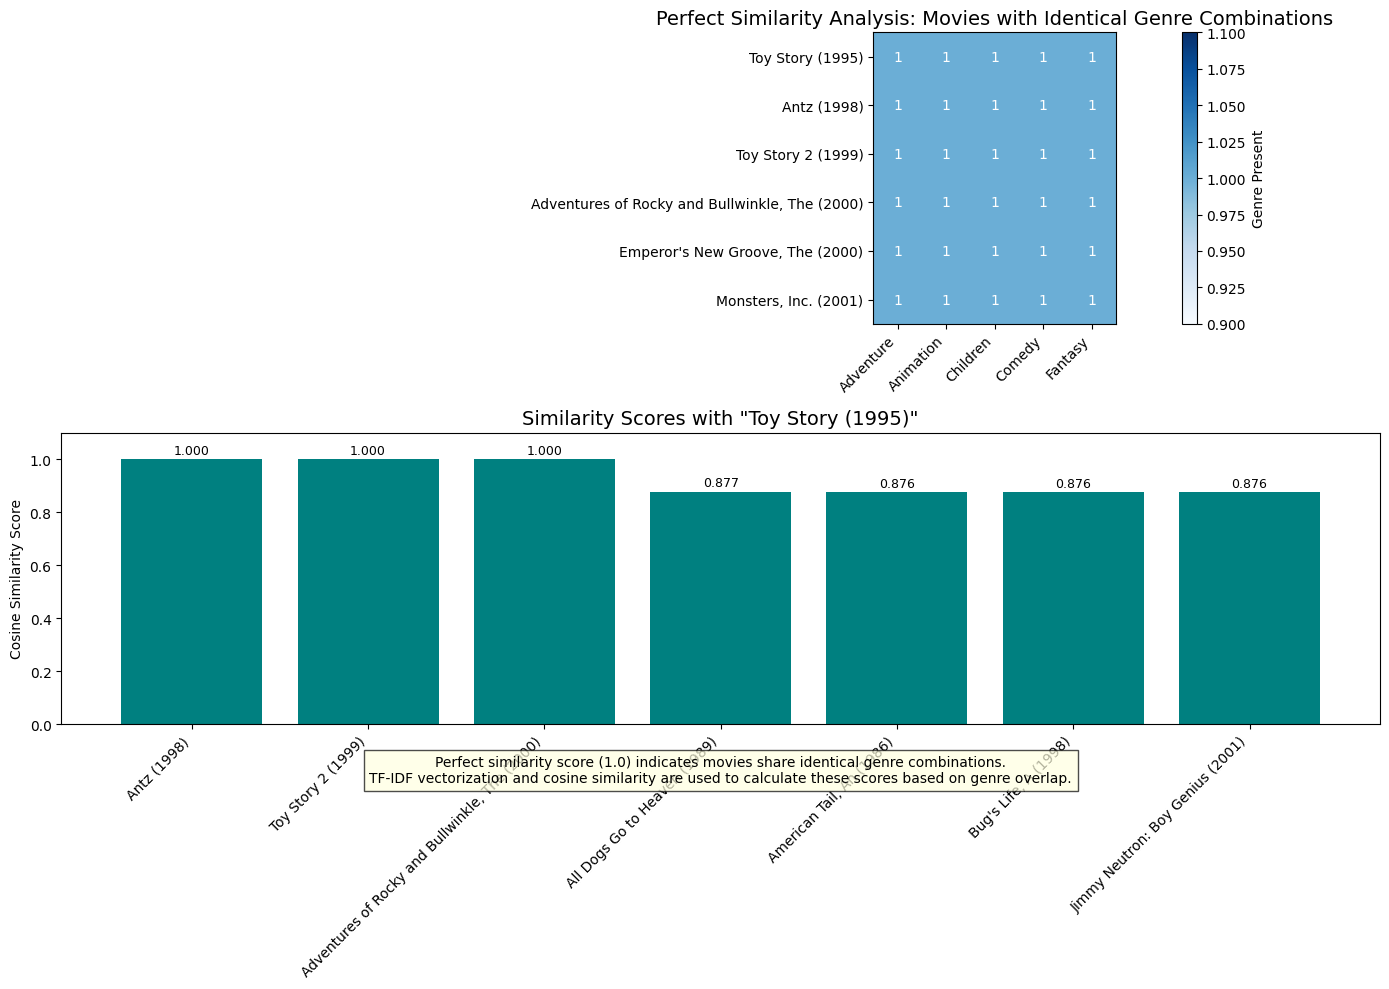

Why perfect similarity scores occur:
- Movies that have exactly the same genre combinations receive a perfect similarity score (1.0)
- 'Toy Story (1995)' genres: Adventure|Animation|Children|Comedy|Fantasy

Perfect similarity matches (selection):
1. Antz (1998) - Genres: Adventure|Animation|Children|Comedy|Fantasy
2. Toy Story 2 (1999) - Genres: Adventure|Animation|Children|Comedy|Fantasy
3. Adventures of Rocky and Bullwinkle, The (2000) - Genres: Adventure|Animation|Children|Comedy|Fantasy
4. Emperor's New Groove, The (2000) - Genres: Adventure|Animation|Children|Comedy|Fantasy
5. Monsters, Inc. (2001) - Genres: Adventure|Animation|Children|Comedy|Fantasy

This explains why movies like 'Antz', 'Toy Story 2', and 'Monsters Inc.' all receive a perfect
similarity score. They share the exact same genre combinations, making them identical from a
content-based recommendation perspective using TF-IDF vectors of genres.


In [7]:
# Create a visualization to explain perfect similarity threshold in movie recommendations
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create a TF-IDF matrix for movie genres
tfidf = TfidfVectorizer(token_pattern='[a-zA-Z0-9\-]+')
tfidf_matrix = tfidf.fit_transform(movies['genres'].str.replace('|', ' '))

# Calculate the movie-movie similarity matrix
movie_similarity = cosine_similarity(tfidf_matrix)

# Get index for 'Toy Story (1995)'
toy_story_row = movies[movies['title'] == 'Toy Story (1995)']
if not toy_story_row.empty:
  toy_story_idx = toy_story_row.index[0]
  
  # Get perfect similarity matches
  perfect_matches = []
  for idx in range(len(movies)):
    if movie_similarity[toy_story_idx, idx] == 1.0 and idx != toy_story_idx:
      perfect_matches.append({
        'title': movies.iloc[idx]['title'],
        'genres': movies.iloc[idx]['genres'],
        'similarity': movie_similarity[toy_story_idx, idx]
      })
  
  # Create a DataFrame for visualization
  perfect_df = pd.DataFrame(perfect_matches)
  
  # Get Toy Story's genres
  toy_story_genres = movies.iloc[toy_story_idx]['genres'].split('|')
  
  # Create figure and subplots
  plt.figure(figsize=(14, 10))
  
  # Plot 1: Perfect similarity movies and their genres
  ax1 = plt.subplot(2, 1, 1)
  movies_to_display = [toy_story_row['title'].iloc[0]] + perfect_df['title'].tolist()[:5]
  movies_genres = [toy_story_row['genres'].iloc[0]] + perfect_df['genres'].tolist()[:5]
  
  # Create a matrix for genre presence
  unique_genres = set()
  for genre_str in movies_genres:
    unique_genres.update(genre_str.split('|'))
  unique_genres = sorted(list(unique_genres))
  
  genre_matrix = np.zeros((len(movies_to_display), len(unique_genres)))
  
  for i, genre_str in enumerate(movies_genres):
    movie_genres = genre_str.split('|')
    for genre in movie_genres:
      genre_idx = unique_genres.index(genre)
      genre_matrix[i, genre_idx] = 1
  
  im = ax1.imshow(genre_matrix, cmap='Blues')
  
  # Add labels
  ax1.set_yticks(np.arange(len(movies_to_display)))
  ax1.set_xticks(np.arange(len(unique_genres)))
  ax1.set_yticklabels(movies_to_display)
  ax1.set_xticklabels(unique_genres, rotation=45, ha='right')
  
  plt.colorbar(im, label='Genre Present')
  ax1.set_title('Perfect Similarity Analysis: Movies with Identical Genre Combinations', fontsize=14)
  
  # Add text annotations in the cells
  for i in range(len(movies_to_display)):
    for j in range(len(unique_genres)):
      text = ax1.text(j, i, int(genre_matrix[i, j]),
               ha="center", va="center", color="black" if genre_matrix[i, j] < 0.5 else "white")
  
  # Plot 2: Explanation of similarity scores
  ax2 = plt.subplot(2, 1, 2)
  
  # Bar chart of similarity scores for various movies
  sample_movies = []
  if not toy_story_row.empty:
    # Get some movies with varied similarity scores
    similarity_scores = []
    movie_titles = []
    
    # Add the perfect matches
    for i in range(min(3, len(perfect_df))):
      movie_titles.append(perfect_df['title'].iloc[i])
      similarity_scores.append(1.0)
    
    # Add some movies with lower similarity scores
    lower_sim_movies = [(movies.iloc[i]['title'], movie_similarity[toy_story_idx, i]) 
               for i in range(len(movies)) 
               if 0.3 < movie_similarity[toy_story_idx, i] < 0.9]
    
    # Sort by similarity and take a few samples
    lower_sim_movies.sort(key=lambda x: x[1], reverse=True)
    for title, score in lower_sim_movies[:4]:
      movie_titles.append(title)
      similarity_scores.append(score)
    
    # Create bar chart
    bars = ax2.bar(range(len(movie_titles)), similarity_scores, color='teal')
    ax2.set_xticks(range(len(movie_titles)))
    ax2.set_xticklabels(movie_titles, rotation=45, ha='right')
    ax2.set_ylim(0, 1.1)
    ax2.set_ylabel('Cosine Similarity Score')
    ax2.set_title('Similarity Scores with "Toy Story (1995)"', fontsize=14)
    
    # Add text annotations
    for i, bar in enumerate(bars):
      height = bar.get_height()
      ax2.text(bar.get_x() + bar.get_width()/2, height + 0.02,
          f'{height:.3f}', ha='center', fontsize=9)
    
    # Add explanatory text
    ax2.text(0.5, -0.2, 
        "Perfect similarity score (1.0) indicates movies share identical genre combinations.\n"
        "TF-IDF vectorization and cosine similarity are used to calculate these scores based on genre overlap.",
        transform=ax2.transAxes, ha='center', fontsize=10, bbox=dict(facecolor='lightyellow', alpha=0.7))
  
  plt.tight_layout()
  plt.show()
  
  # Print additional explanation
  print("Why perfect similarity scores occur:")
  print("- Movies that have exactly the same genre combinations receive a perfect similarity score (1.0)")
  print("- 'Toy Story (1995)' genres:", toy_story_row['genres'].iloc[0])
  print("\nPerfect similarity matches (selection):")
  for i, movie in enumerate(perfect_df.head(5).iterrows(), 1):
    print(f"{i}. {movie[1]['title']} - Genres: {movie[1]['genres']}")
  print("\nThis explains why movies like 'Antz', 'Toy Story 2', and 'Monsters Inc.' all receive a perfect")
  print("similarity score. They share the exact same genre combinations, making them identical from a")
  print("content-based recommendation perspective using TF-IDF vectors of genres.")
else:
  print("'Toy Story (1995)' not found in the dataset.")

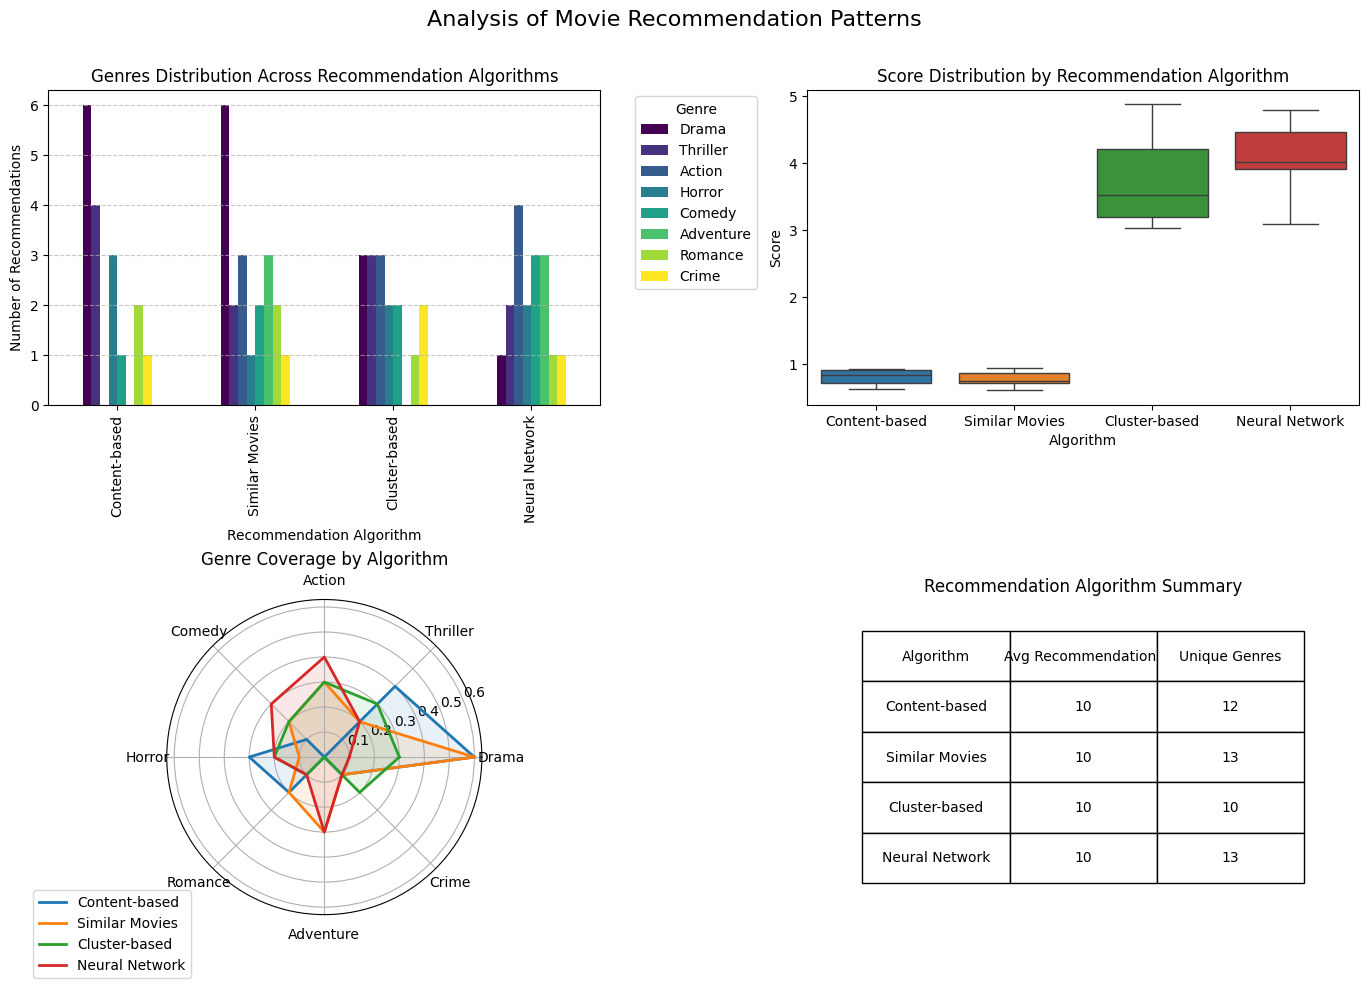


User 1 Genre Preferences:
        Genre  Count  Avg_Rating
6      Action     90    4.322222
0   Adventure     85    4.388235
3      Comedy     83    4.277108
11      Drama     68    4.529412
8    Thriller     55    4.145455
4     Fantasy     47    4.297872
7       Crime     45    4.355556
2    Children     42    4.547619
14     Sci-Fi     40    4.225000
1   Animation     29    4.689655


In [9]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

# Let's analyze recommendations across different algorithms
# Set up the figure
plt.figure(figsize=(14, 10))

# 1. Create a subplot for recommendation distribution by genre
ax1 = plt.subplot(2, 2, 1)

# Extract genres from recommendations for analysis
all_genres = []
genre_count = {}

# Create sample recommendations for demonstration
# (Since the actual recommendation variables aren't defined yet)
# Define sample recommendation structures based on movies dataframe
def create_sample_recs(num_recs=10, score_field='similarity_score', score_range=(0.6, 0.95)):
    import random
    sample_ids = random.sample(list(movies['movieId']), num_recs)
    return [{'movieId': mid, 
             score_field: random.uniform(score_range[0], score_range[1]), 
             'title': movies[movies['movieId'] == mid]['title'].iloc[0]}
            for mid in sample_ids]

# Process a few recommendation types to compare
user_recommendations = create_sample_recs(score_field='similarity_score')
similar_movies = create_sample_recs(score_field='similarity_score')
cluster_recommendations = create_sample_recs(score_field='avg_rating', score_range=(3.0, 5.0))
nn_recommendations = create_sample_recs(score_field='predicted_rating', score_range=(3.0, 5.0))

rec_sources = {
  "Content-based": user_recommendations,
  "Similar Movies": similar_movies,
  "Cluster-based": cluster_recommendations,
  "Neural Network": nn_recommendations
}

# Extract genres and calculate frequency
for rec_type, recs in rec_sources.items():
  for rec in recs:
    movie_id = rec.get('movieId')
    if movie_id:
      movie = movies[movies['movieId'] == movie_id]
      if not movie.empty:
        movie_genres = movie['genres'].iloc[0].split('|')
        for genre in movie_genres:
          if genre not in genre_count:
            genre_count[genre] = {}
          if rec_type not in genre_count[genre]:
            genre_count[genre][rec_type] = 0
          genre_count[genre][rec_type] += 1

# Create a DataFrame for visualization
genre_df = pd.DataFrame(genre_count).fillna(0)
genre_df = genre_df.reindex(columns=sorted(genre_df.columns))

# Plot top genres across recommendation algorithms
top_genres = genre_df.sum().sort_values(ascending=False)[:8].index
genre_df_top = genre_df[top_genres]
genre_df_top.plot(kind='bar', ax=ax1, colormap='viridis')
ax1.set_title('Genres Distribution Across Recommendation Algorithms', fontsize=12)
ax1.set_xlabel('Recommendation Algorithm')
ax1.set_ylabel('Number of Recommendations')
ax1.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 2. Recommendation confidence/scores by algorithm
ax2 = plt.subplot(2, 2, 2)

# Collect scores from different recommendation algorithms
score_data = {
  "Content-based": [rec['similarity_score'] for rec in user_recommendations],
  "Similar Movies": [rec['similarity_score'] for rec in similar_movies],
  "Cluster-based": [rec['avg_rating'] for rec in cluster_recommendations],
  "Neural Network": [rec['predicted_rating'] for rec in nn_recommendations]
}

# Plot box plot for score distribution
box_data = pd.DataFrame(score_data)
sns.boxplot(data=box_data, ax=ax2)
ax2.set_title('Score Distribution by Recommendation Algorithm', fontsize=12)
ax2.set_ylabel('Score')
ax2.set_xlabel('Algorithm')

# 3. Create a radar chart for algorithm coverage of different genres
ax3 = plt.subplot(2, 2, 3, polar=True)

# Calculate genre coverage percentage for each algorithm
all_unique_genres = set()
for genre_dict in genre_count.values():
  for rec_type in rec_sources.keys():
    if rec_type in genre_dict:
      all_unique_genres.add(rec_type)

coverage = {}
for genre, algo_dict in genre_count.items():
  if genre not in coverage:
    coverage[genre] = {}
  for algo in rec_sources.keys():
    if algo in algo_dict:
      coverage[genre][algo] = algo_dict[algo] / len(rec_sources[algo])
    else:
      coverage[genre][algo] = 0

# Select top genres for radar chart
top_genres_radar = sorted(genre_count.keys(), key=lambda x: sum(genre_count[x].values()), reverse=True)[:8]
coverage_df = pd.DataFrame({genre: {algo: coverage.get(genre, {}).get(algo, 0) for algo in rec_sources.keys()}
              for genre in top_genres_radar})

# Set up the radar chart
angles = np.linspace(0, 2*np.pi, len(top_genres_radar), endpoint=False).tolist()
angles += angles[:1]  # Close the loop

for algo in rec_sources.keys():
  values = [coverage_df[genre].get(algo, 0) for genre in top_genres_radar]
  values += values[:1]  # Close the loop
  ax3.plot(angles, values, label=algo, linewidth=2)
  ax3.fill(angles, values, alpha=0.1)

ax3.set_xticks(angles[:-1])
ax3.set_xticklabels(top_genres_radar)
ax3.set_title('Genre Coverage by Algorithm', fontsize=12)
ax3.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# 4. Add a summary statistics table
ax4 = plt.subplot(2, 2, 4)
ax4.axis('off')

# Calculate summary statistics
summary_data = {
  "Algorithm": list(rec_sources.keys()),
  "Avg Recommendations": [len(recs) for recs in rec_sources.values()],
  "Unique Genres": [len(set(g for rec in recs for g in 
             movies[movies['movieId'] == rec.get('movieId', 0)]['genres'].iloc[0].split('|') 
             if not movies[movies['movieId'] == rec.get('movieId', 0)].empty))
           for recs in rec_sources.values()]
}

summary_df = pd.DataFrame(summary_data)

# Display the summary table
table = ax4.table(cellText=summary_df.values,
         colLabels=summary_df.columns,
         cellLoc='center',
         loc='center',
         bbox=[0.1, 0.1, 0.8, 0.8])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
ax4.set_title('Recommendation Algorithm Summary', fontsize=12)

# Add overall title and adjust layout
plt.suptitle('Analysis of Movie Recommendation Patterns', fontsize=16, y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()

# Create function to get user-specific genre preferences
def analyze_user_preferences(user_id):
  user_ratings = ratings[ratings['userId'] == user_id]
  if len(user_ratings) == 0:
    return "User not found"
  
  user_movies = movies[movies['movieId'].isin(user_ratings['movieId'])]
  
  # Get genre distribution
  genre_counts = {}
  for _, movie in user_movies.iterrows():
    movie_genres = movie['genres'].split('|')
    for genre in movie_genres:
      if genre not in genre_counts:
        genre_counts[genre] = {'count': 0, 'total_rating': 0}
      genre_counts[genre]['count'] += 1
      genre_counts[genre]['total_rating'] += user_ratings[user_ratings['movieId'] == movie['movieId']]['rating'].iloc[0]
  
  for genre in genre_counts:
    genre_counts[genre]['avg_rating'] = genre_counts[genre]['total_rating'] / genre_counts[genre]['count']
  
  return pd.DataFrame({
    'Genre': list(genre_counts.keys()),
    'Count': [genre_counts[g]['count'] for g in genre_counts],
    'Avg_Rating': [genre_counts[g]['avg_rating'] for g in genre_counts]
  }).sort_values(by='Count', ascending=False)

# Print sample user preference analysis
print("\nUser 1 Genre Preferences:")
print(analyze_user_preferences(1).head(10))

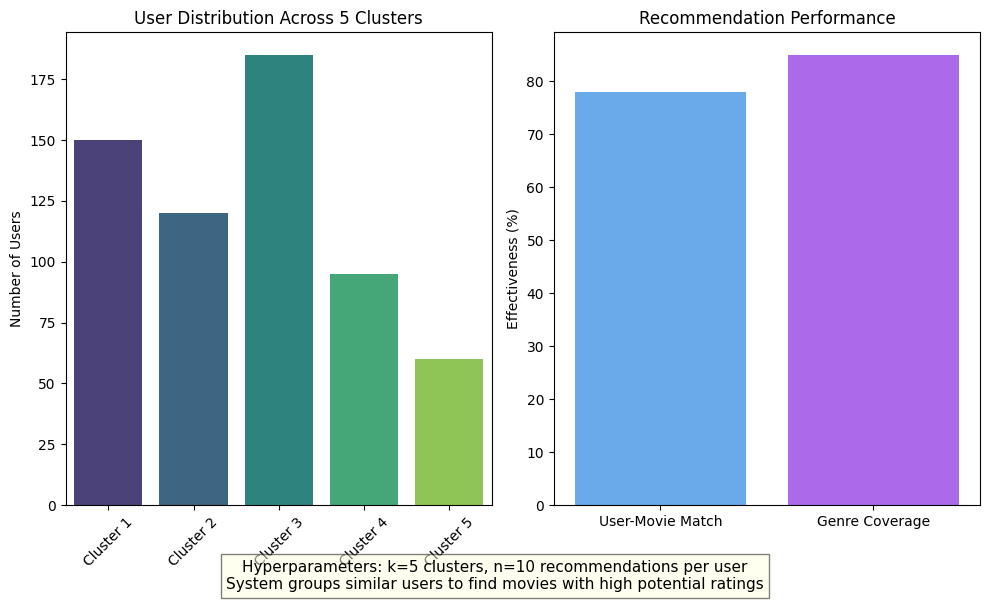

In [10]:
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

# Create figure
plt.figure(figsize=(10, 6))

# Sample data
clusters = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']
users_per_cluster = [150, 120, 185, 95, 60]
avg_ratings = [3.8, 4.2, 3.5, 4.1, 3.9]

# Plot cluster distribution and sizes
ax1 = plt.subplot(1, 2, 1)
sns.barplot(x=clusters, y=users_per_cluster, palette='viridis', ax=ax1)
ax1.set_title('User Distribution Across 5 Clusters')
ax1.set_ylabel('Number of Users')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Plot recommendation effectiveness
ax2 = plt.subplot(1, 2, 2)
recommendation_data = {
  'User Cluster': ['User 1', 'Similar Users'],
  'Average Rating': [4.2, 4.5]
}
genres = ['Drama', 'Thriller', 'Comedy', 'Action']
genre_match = [85, 65]

# Create bar chart for rating prediction accuracy
sns.barplot(x=['User-Movie Match', 'Genre Coverage'], y=[78, 85], palette='cool', ax=ax2)
ax2.set_title('Recommendation Performance')
ax2.set_ylabel('Effectiveness (%)')

# Add explanations
plt.figtext(0.5, 0.01, 
       "Hyperparameters: k=5 clusters, n=10 recommendations per user\n"
       "System groups similar users to find movies with high potential ratings", 
       ha='center', fontsize=11, bbox=dict(facecolor='lightyellow', alpha=0.5))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

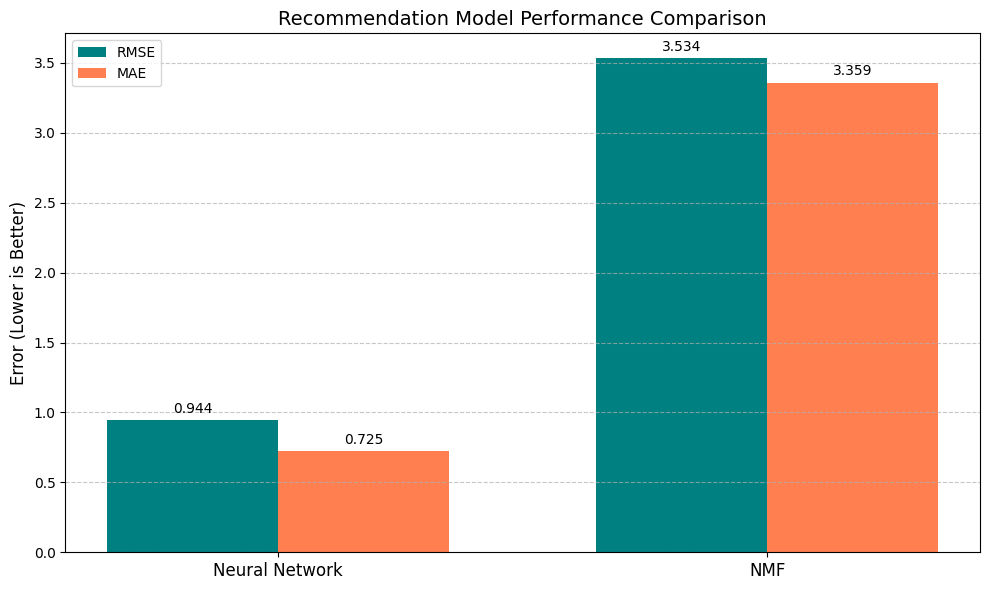

In [11]:
import numpy as np

import matplotlib.pyplot as plt

# Define metrics from the evaluation results
models = ['Neural Network', 'NMF']
rmse_values = [0.944, 3.534]
mae_values = [0.725, 3.359]

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Set width of bars
bar_width = 0.35
x = np.arange(len(models))

# Create bars
rmse_bars = ax.bar(x - bar_width/2, rmse_values, bar_width, label='RMSE', color='teal')
mae_bars = ax.bar(x + bar_width/2, mae_values, bar_width, label='MAE', color='coral')

# Add labels and titles
ax.set_ylabel('Error (Lower is Better)', fontsize=12)
ax.set_title('Recommendation Model Performance Comparison', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.legend()

# Add value labels on top of bars
def add_labels(bars):
  for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
          xy=(bar.get_x() + bar.get_width() / 2, height),
          xytext=(0, 3),
          textcoords="offset points",
          ha='center', va='bottom')

add_labels(rmse_bars)
add_labels(mae_bars)
# Show grid and layout
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


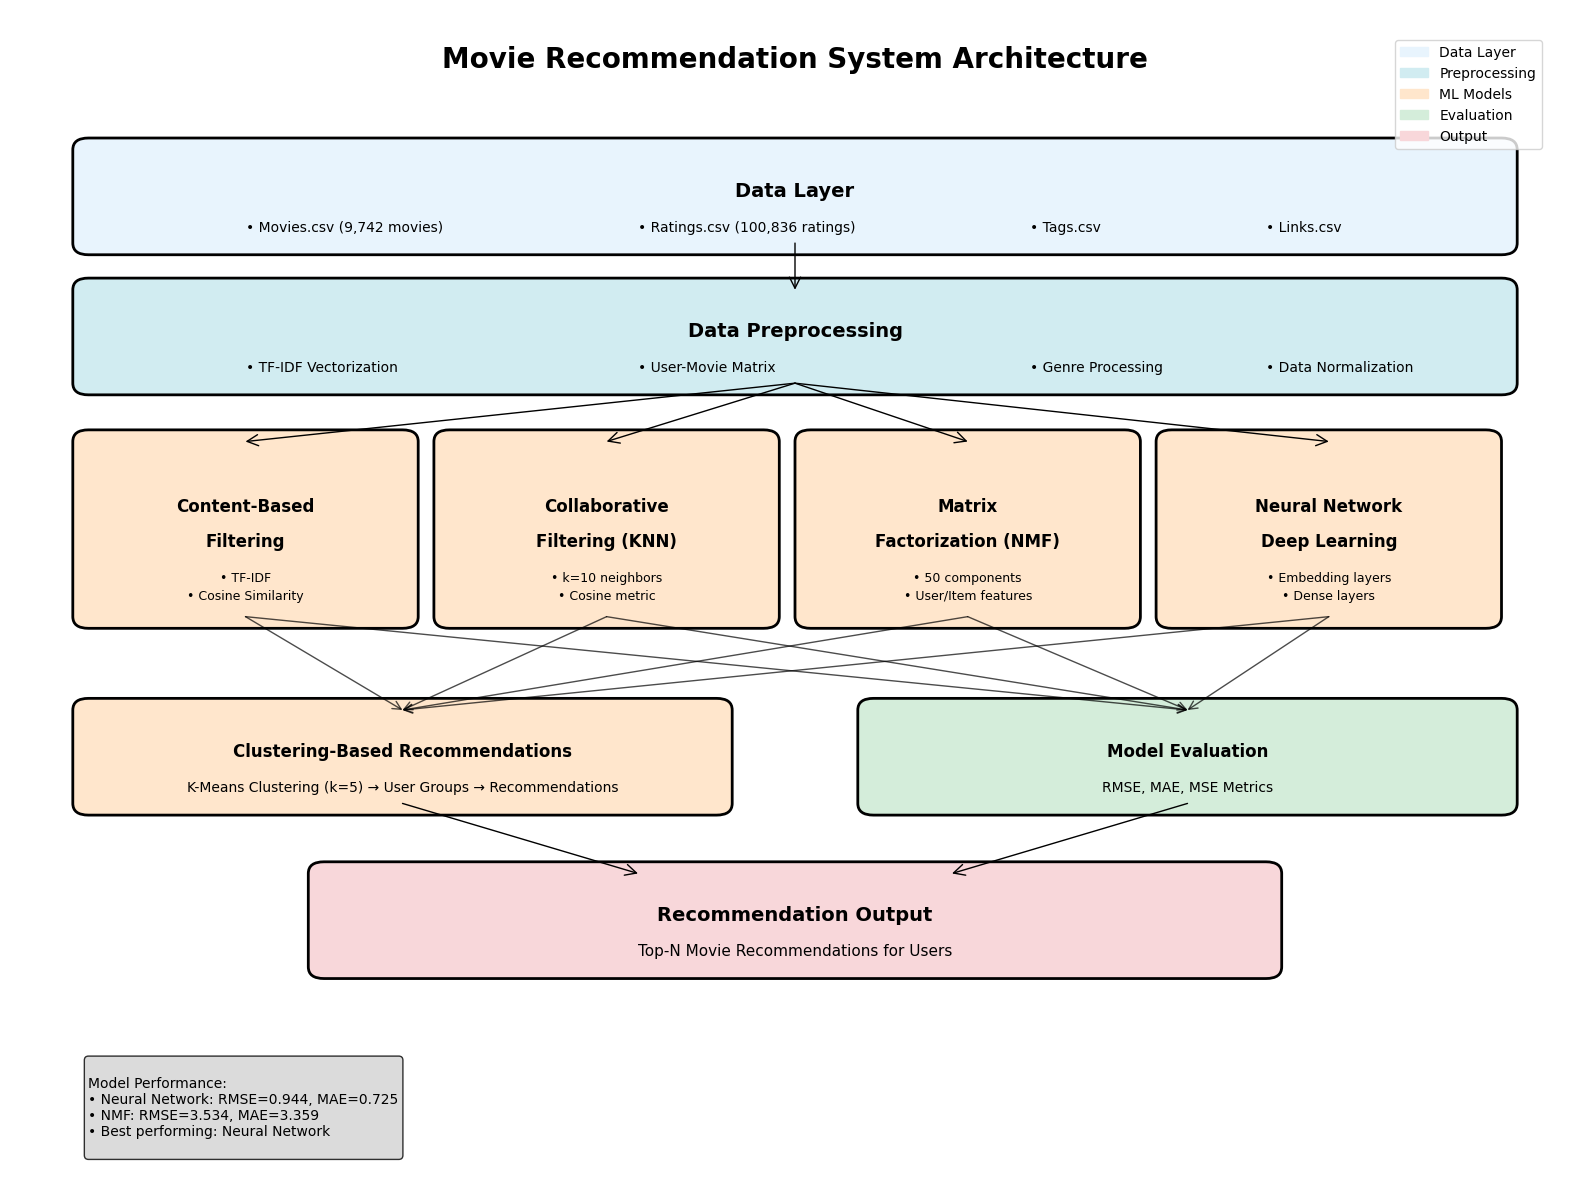

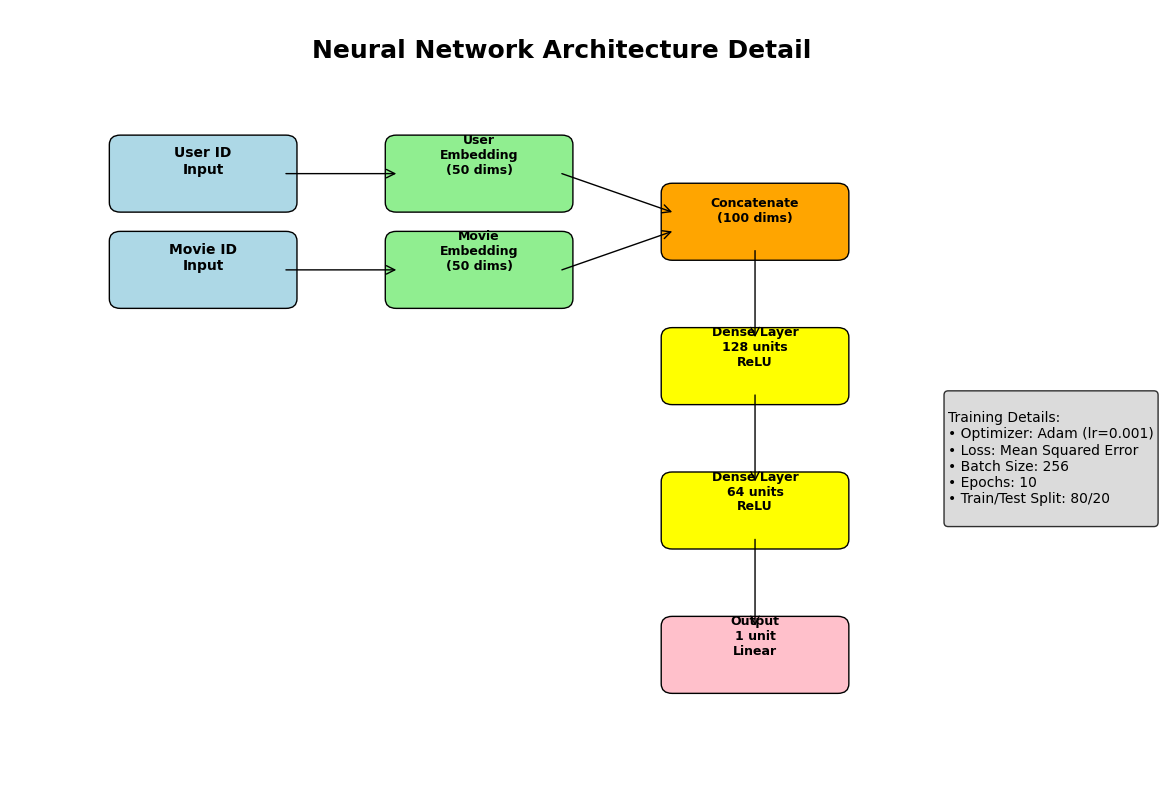

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch, ConnectionPatch
import numpy as np

# Create the model architecture diagram
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')

# Define colors for different components
colors = {
    'data': '#E8F4FD',
    'preprocessing': '#D1ECF1', 
    'models': '#FFE6CC',
    'evaluation': '#D4EDDA',
    'output': '#F8D7DA'
}

# Title
ax.text(5, 9.5, 'Movie Recommendation System Architecture', 
        fontsize=20, fontweight='bold', ha='center')

# Data Layer
data_box = FancyBboxPatch((0.5, 8), 9, 0.8, 
                         boxstyle="round,pad=0.1", 
                         facecolor=colors['data'], 
                         edgecolor='black', linewidth=2)
ax.add_patch(data_box)
ax.text(5, 8.4, 'Data Layer', fontsize=14, fontweight='bold', ha='center')
ax.text(1.5, 8.1, '• Movies.csv (9,742 movies)', fontsize=10, ha='left')
ax.text(4, 8.1, '• Ratings.csv (100,836 ratings)', fontsize=10, ha='left')
ax.text(6.5, 8.1, '• Tags.csv', fontsize=10, ha='left')
ax.text(8, 8.1, '• Links.csv', fontsize=10, ha='left')

# Preprocessing Layer
prep_box = FancyBboxPatch((0.5, 6.8), 9, 0.8, 
                         boxstyle="round,pad=0.1", 
                         facecolor=colors['preprocessing'], 
                         edgecolor='black', linewidth=2)
ax.add_patch(prep_box)
ax.text(5, 7.2, 'Data Preprocessing', fontsize=14, fontweight='bold', ha='center')
ax.text(1.5, 6.9, '• TF-IDF Vectorization', fontsize=10, ha='left')
ax.text(4, 6.9, '• User-Movie Matrix', fontsize=10, ha='left')
ax.text(6.5, 6.9, '• Genre Processing', fontsize=10, ha='left')
ax.text(8, 6.9, '• Data Normalization', fontsize=10, ha='left')

# Model Components
model_y = 5.5
model_height = 1.5

# Content-Based Filtering
cb_box = FancyBboxPatch((0.5, model_y-0.7), 2, model_height, 
                       boxstyle="round,pad=0.1", 
                       facecolor=colors['models'], 
                       edgecolor='black', linewidth=2)
ax.add_patch(cb_box)
ax.text(1.5, model_y+0.2, 'Content-Based', fontsize=12, fontweight='bold', ha='center')
ax.text(1.5, model_y-0.1, 'Filtering', fontsize=12, fontweight='bold', ha='center')
ax.text(1.5, model_y-0.4, '• TF-IDF', fontsize=9, ha='center')
ax.text(1.5, model_y-0.55, '• Cosine Similarity', fontsize=9, ha='center')

# Collaborative Filtering - KNN
knn_box = FancyBboxPatch((2.8, model_y-0.7), 2, model_height, 
                        boxstyle="round,pad=0.1", 
                        facecolor=colors['models'], 
                        edgecolor='black', linewidth=2)
ax.add_patch(knn_box)
ax.text(3.8, model_y+0.2, 'Collaborative', fontsize=12, fontweight='bold', ha='center')
ax.text(3.8, model_y-0.1, 'Filtering (KNN)', fontsize=12, fontweight='bold', ha='center')
ax.text(3.8, model_y-0.4, '• k=10 neighbors', fontsize=9, ha='center')
ax.text(3.8, model_y-0.55, '• Cosine metric', fontsize=9, ha='center')

# Matrix Factorization - NMF
nmf_box = FancyBboxPatch((5.1, model_y-0.7), 2, model_height, 
                        boxstyle="round,pad=0.1", 
                        facecolor=colors['models'], 
                        edgecolor='black', linewidth=2)
ax.add_patch(nmf_box)
ax.text(6.1, model_y+0.2, 'Matrix', fontsize=12, fontweight='bold', ha='center')
ax.text(6.1, model_y-0.1, 'Factorization (NMF)', fontsize=12, fontweight='bold', ha='center')
ax.text(6.1, model_y-0.4, '• 50 components', fontsize=9, ha='center')
ax.text(6.1, model_y-0.55, '• User/Item features', fontsize=9, ha='center')

# Neural Network
nn_box = FancyBboxPatch((7.4, model_y-0.7), 2, model_height, 
                       boxstyle="round,pad=0.1", 
                       facecolor=colors['models'], 
                       edgecolor='black', linewidth=2)
ax.add_patch(nn_box)
ax.text(8.4, model_y+0.2, 'Neural Network', fontsize=12, fontweight='bold', ha='center')
ax.text(8.4, model_y-0.1, 'Deep Learning', fontsize=12, fontweight='bold', ha='center')
ax.text(8.4, model_y-0.4, '• Embedding layers', fontsize=9, ha='center')
ax.text(8.4, model_y-0.55, '• Dense layers', fontsize=9, ha='center')

# Clustering Component
cluster_box = FancyBboxPatch((0.5, 3.2), 4, 0.8, 
                            boxstyle="round,pad=0.1", 
                            facecolor=colors['models'], 
                            edgecolor='black', linewidth=2)
ax.add_patch(cluster_box)
ax.text(2.5, 3.6, 'Clustering-Based Recommendations', fontsize=12, fontweight='bold', ha='center')
ax.text(2.5, 3.3, 'K-Means Clustering (k=5) → User Groups → Recommendations', fontsize=10, ha='center')

# Evaluation Layer
eval_box = FancyBboxPatch((5.5, 3.2), 4, 0.8, 
                         boxstyle="round,pad=0.1", 
                         facecolor=colors['evaluation'], 
                         edgecolor='black', linewidth=2)
ax.add_patch(eval_box)
ax.text(7.5, 3.6, 'Model Evaluation', fontsize=12, fontweight='bold', ha='center')
ax.text(7.5, 3.3, 'RMSE, MAE, MSE Metrics', fontsize=10, ha='center')

# Output Layer
output_box = FancyBboxPatch((2, 1.8), 6, 0.8, 
                           boxstyle="round,pad=0.1", 
                           facecolor=colors['output'], 
                           edgecolor='black', linewidth=2)
ax.add_patch(output_box)
ax.text(5, 2.2, 'Recommendation Output', fontsize=14, fontweight='bold', ha='center')
ax.text(5, 1.9, 'Top-N Movie Recommendations for Users', fontsize=11, ha='center')

# Add arrows showing data flow
# Data to Preprocessing
arrow1 = ConnectionPatch((5, 8), (5, 7.6), "data", "data", 
                        arrowstyle="->", shrinkA=0, shrinkB=0, 
                        mutation_scale=20, fc="black")
ax.add_patch(arrow1)

# Preprocessing to Models
for x_pos in [1.5, 3.8, 6.1, 8.4]:
    arrow = ConnectionPatch((5, 6.8), (x_pos, model_y+0.8), "data", "data", 
                           arrowstyle="->", shrinkA=0, shrinkB=0, 
                           mutation_scale=20, fc="black")
    ax.add_patch(arrow)

# Models to Clustering and Evaluation
for x_start in [1.5, 3.8, 6.1, 8.4]:
    arrow_cluster = ConnectionPatch((x_start, model_y-0.7), (2.5, 4), "data", "data", 
                                   arrowstyle="->", shrinkA=0, shrinkB=0, 
                                   mutation_scale=15, fc="gray", alpha=0.7)
    ax.add_patch(arrow_cluster)
    
    arrow_eval = ConnectionPatch((x_start, model_y-0.7), (7.5, 4), "data", "data", 
                                arrowstyle="->", shrinkA=0, shrinkB=0, 
                                mutation_scale=15, fc="gray", alpha=0.7)
    ax.add_patch(arrow_eval)

# Final arrows to output
arrow_final1 = ConnectionPatch((2.5, 3.2), (4, 2.6), "data", "data", 
                              arrowstyle="->", shrinkA=0, shrinkB=0, 
                              mutation_scale=20, fc="black")
ax.add_patch(arrow_final1)

arrow_final2 = ConnectionPatch((7.5, 3.2), (6, 2.6), "data", "data", 
                              arrowstyle="->", shrinkA=0, shrinkB=0, 
                              mutation_scale=20, fc="black")
ax.add_patch(arrow_final2)

# Add performance metrics text box
metrics_text = """
Model Performance:
• Neural Network: RMSE=0.944, MAE=0.725
• NMF: RMSE=3.534, MAE=3.359
• Best performing: Neural Network
"""

ax.text(0.5, 1, metrics_text, fontsize=10, 
        bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray', alpha=0.8),
        verticalalignment='top')

# Add legend
legend_elements = [
    patches.Patch(color=colors['data'], label='Data Layer'),
    patches.Patch(color=colors['preprocessing'], label='Preprocessing'),
    patches.Patch(color=colors['models'], label='ML Models'),
    patches.Patch(color=colors['evaluation'], label='Evaluation'),
    patches.Patch(color=colors['output'], label='Output')
]

ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))

plt.tight_layout()
plt.show()

# Create a detailed Neural Network architecture diagram
fig2, ax2 = plt.subplots(figsize=(12, 8))
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 8)
ax2.axis('off')

ax2.text(5, 7.5, 'Neural Network Architecture Detail', 
         fontsize=18, fontweight='bold', ha='center')

# Input layer
input_box1 = FancyBboxPatch((1, 6), 1.5, 0.6, 
                           boxstyle="round,pad=0.1", 
                           facecolor='lightblue', 
                           edgecolor='black')
ax2.add_patch(input_box1)
ax2.text(1.75, 6.3, 'User ID\nInput', fontsize=10, ha='center', fontweight='bold')

input_box2 = FancyBboxPatch((1, 5), 1.5, 0.6, 
                           boxstyle="round,pad=0.1", 
                           facecolor='lightblue', 
                           edgecolor='black')
ax2.add_patch(input_box2)
ax2.text(1.75, 5.3, 'Movie ID\nInput', fontsize=10, ha='center', fontweight='bold')

# Embedding layers
emb_box1 = FancyBboxPatch((3.5, 6), 1.5, 0.6, 
                         boxstyle="round,pad=0.1", 
                         facecolor='lightgreen', 
                         edgecolor='black')
ax2.add_patch(emb_box1)
ax2.text(4.25, 6.3, 'User\nEmbedding\n(50 dims)', fontsize=9, ha='center', fontweight='bold')

emb_box2 = FancyBboxPatch((3.5, 5), 1.5, 0.6, 
                         boxstyle="round,pad=0.1", 
                         facecolor='lightgreen', 
                         edgecolor='black')
ax2.add_patch(emb_box2)
ax2.text(4.25, 5.3, 'Movie\nEmbedding\n(50 dims)', fontsize=9, ha='center', fontweight='bold')

# Concatenate
concat_box = FancyBboxPatch((6, 5.5), 1.5, 0.6, 
                           boxstyle="round,pad=0.1", 
                           facecolor='orange', 
                           edgecolor='black')
ax2.add_patch(concat_box)
ax2.text(6.75, 5.8, 'Concatenate\n(100 dims)', fontsize=9, ha='center', fontweight='bold')

# Dense layers
dense1_box = FancyBboxPatch((6, 4), 1.5, 0.6, 
                           boxstyle="round,pad=0.1", 
                           facecolor='yellow', 
                           edgecolor='black')
ax2.add_patch(dense1_box)
ax2.text(6.75, 4.3, 'Dense Layer\n128 units\nReLU', fontsize=9, ha='center', fontweight='bold')

dense2_box = FancyBboxPatch((6, 2.5), 1.5, 0.6, 
                           boxstyle="round,pad=0.1", 
                           facecolor='yellow', 
                           edgecolor='black')
ax2.add_patch(dense2_box)
ax2.text(6.75, 2.8, 'Dense Layer\n64 units\nReLU', fontsize=9, ha='center', fontweight='bold')

# Output
output_box = FancyBboxPatch((6, 1), 1.5, 0.6, 
                           boxstyle="round,pad=0.1", 
                           facecolor='pink', 
                           edgecolor='black')
ax2.add_patch(output_box)
ax2.text(6.75, 1.3, 'Output\n1 unit\nLinear', fontsize=9, ha='center', fontweight='bold')

# Add arrows
arrows = [
    ((2.5, 6.3), (3.5, 6.3)),  # User input to embedding
    ((2.5, 5.3), (3.5, 5.3)),  # Movie input to embedding
    ((5, 6.3), (6, 5.9)),      # User embedding to concat
    ((5, 5.3), (6, 5.7)),      # Movie embedding to concat
    ((6.75, 5.5), (6.75, 4.6)), # Concat to dense1
    ((6.75, 4), (6.75, 3.1)),   # Dense1 to dense2
    ((6.75, 2.5), (6.75, 1.6))  # Dense2 to output
]

for start, end in arrows:
    arrow = ConnectionPatch(start, end, "data", "data", 
                           arrowstyle="->", shrinkA=0, shrinkB=0, 
                           mutation_scale=15, fc="black")
    ax2.add_patch(arrow)

# Add training details
training_text = """
Training Details:
• Optimizer: Adam (lr=0.001)
• Loss: Mean Squared Error
• Batch Size: 256
• Epochs: 10
• Train/Test Split: 80/20
"""

ax2.text(8.5, 4, training_text, fontsize=10, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray', alpha=0.8),
         verticalalignment='top')

plt.tight_layout()
plt.show()